<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Keep part in this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

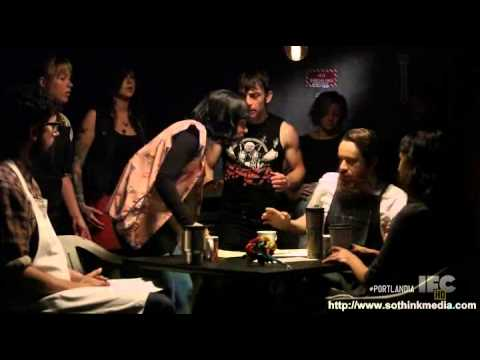

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
import pandas as pd

shops = pd.read_csv('./data/yelp_coffeeshop_review_data.csv')
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [3]:
# Start here
shops['rating'] = shops['star_rating'].apply(lambda x: x.replace(' star rating', '')).astype('float')

In [4]:
shops['data'] = shops['full_review_text'].apply(lambda x: x.split()[0])
shops['full_review_text'] = shops['full_review_text'].apply(lambda x: " ".join(x.split()[1:]))

In [5]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,rating,data
0,The Factory - Cafe With a Soul,1 check-in Love love loved the atmosphere! Eve...,5.0 star rating,5.0,11/25/2016
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aust...",4.0 star rating,4.0,12/2/2016
2,The Factory - Cafe With a Soul,1 check-in Listed in Brunch Spots I loved the ...,4.0 star rating,4.0,11/30/2016
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating Howe...,2.0 star rating,2.0,11/25/2016
4,The Factory - Cafe With a Soul,1 check-in They are located within the Northcr...,4.0 star rating,4.0,12/3/2016


In [6]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [7]:
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [8]:
shops['token'] = shops['full_review_text'].apply(get_lemmas)

In [9]:
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

# How do we want to analyze these coffee shop tokens?

- overall word/token count
- vew counts by rating


In [13]:
wc = count(shops['token'])

In [ ]:
shops[tokens]

In [14]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
13,coffee,4848,10153,1.0,0.028068,0.028068,0.636555
76,place,3879,6026,2.0,0.016659,0.044728,0.509322
159,good,3590,5393,3.0,0.014909,0.059637,0.471376
65,great,2843,3924,4.0,0.010848,0.070485,0.373293
25,check,3175,3467,5.0,0.009585,0.080070,0.416886


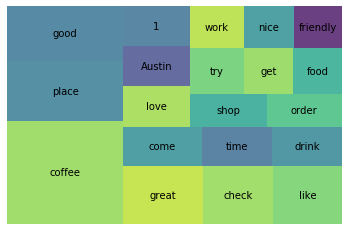

In [17]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=0.8)
plt.axis('off')
plt.show()

In [18]:
shops['coffee_shop_name'].nunique()

79

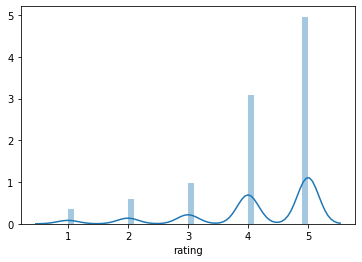

In [19]:
import seaborn as sns

sns.distplot(shops['rating']);

In [20]:
shops.rating.describe()

count    7616.000000
mean        4.169118
std         1.065311
min         1.000000
25%         4.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

In [21]:
# A 'bad coffee shop has a rating between 1 and 3 based on the distribution of ratings.

In [23]:
wc_bad = count(shops[shops['rating'] < 4]['token'])

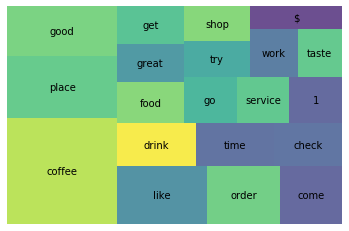

In [24]:
import squarify
import matplotlib.pyplot as plt

wc_top20_bad = wc_bad[wc_bad['rank'] <= 20]

squarify.plot(sizes=wc_top20_bad['pct_total'], label=wc_top20_bad['word'], alpha=0.8)
plt.axis('off')
plt.show()

In [26]:
wc_good = count(shops[shops['rating'] >= 4]['token'])

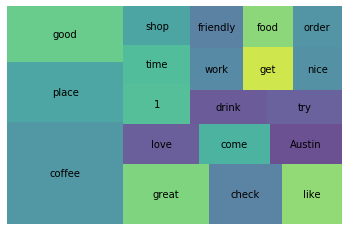

In [27]:
wc_top20_good = wc_good[wc_good['rank'] <= 20]

squarify.plot(sizes=wc_top20_good['pct_total'], label=wc_top20_good['word'], alpha=0.8)
plt.axis('off')
plt.show()

## Can visualize the words with the greatest difference in counts between 'good' and 'bad'?:

Couple notes
- rel freq indstead of absolute counts b/c diff number of reviews
- only look at top 5-10 words w/ the greatest differences

In [48]:
wc_bad['appears_in_pct_bad'] = wc_bad['appears_in_pct']
diff = wc_good[['word', 'appears_in_pct']].merge(wc_bad[['word', 'appears_in_pct_bad']], how='outer')

In [49]:
diff.head(20)

,word,appears_in_pct,appears_in_pct_bad
0,coffee,0.637785,0.631436
1,place,0.508958,0.510840
2,good,0.480130,0.434959
3,great,0.406678,0.234417
4,check,0.437459,0.331301
5,like,0.273127,0.403794
6,love,0.258958,0.141599
7,come,0.241205,0.306233
8,Austin,0.251303,0.163957
9,1,0.280293,0.285908


In [51]:
diff['diff'] = diff['appears_in_pct'] - diff['appears_in_pct_bad']

In [54]:
diff.sort_values(by='diff').head(20)

,word,appears_in_pct,appears_in_pct_bad,diff
5,like,0.273127,0.403794,-0.130667
19,order,0.166287,0.292005,-0.125719
139,ask,0.050651,0.149051,-0.098400
36,service,0.138274,0.234417,-0.096144
209,bad,0.036645,0.128726,-0.092081
26,go,0.140228,0.228320,-0.088092
49,taste,0.106026,0.189702,-0.083676
87,$,0.064169,0.147696,-0.083527
161,customer,0.044788,0.126016,-0.081228
150,say,0.047231,0.126016,-0.078785


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play the the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

